In [108]:
import pandas as pd 
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import tree
import os
import pydotplus

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\RGS New Cust")

# Read Data

In [109]:
df = pd.read_csv(os.getcwd()+r"\Data Files\phantomas_backscored.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [110]:
df.head()

,SKP_CREDIT_CASE,DECISION_OVERALL,TIME_CREATION_DATE,DP_PCT,PRODUCT_GOODS_TYPE,PRODUCT_CREDIT_TYPE,AMT_CREDIT,POS_TYPE,POS_GSPN_V2,PAYU_SEGMENT,...,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,FLAG_1PCT_PHANTOM,DECISION_REASON_GROUP,PRODUCT_INSURANCE,VMM_FNF,PENNY_FNF,TP_FNF
0,306282502,Approved,01-06-20,0.369,c_Mob_Tab,ZERO,10089,Satellite,1.0,NOT_FOUND,...,0,0,0,0,1,PRE_RGS,MAX_INS,NaN,NaN,NOT_FOUND
1,306283929,Approved,01-06-20,0.300,c_Mob_Tab,ZERO,9098,Satellite,2.0,NOT_FOUND,...,0,0,0,0,1,PRE_RGS,MAX_INS,NOT_FOUND,NaN,NOT_FOUND
2,306284197,Approved,01-06-20,0.318,c_Mob_Tab,STANDARD,5799,AP,NaN,NOT_FOUND,...,0,0,0,0,1,PRE_RGS,MAX_INS,NaN,SUCCESS,NOT_FOUND
3,306284217,Approved,01-06-20,0.401,e_HA,ZERO,17374,AP,2.0,FOUND_DORMANT,...,0,0,0,0,1,POST_RGS,NO INSURANCE,NaN,NaN,NOT_FOUND
4,306284405,Approved,01-06-20,0.335,c_Mob_Tab,STANDARD,12299,Satellite,2.0,NOT_FOUND,...,0,0,0,0,1,PRE_RGS,NO INSURANCE,NaN,NaN,NOT_FOUND


In [111]:
df.columns

Index(['SKP_CREDIT_CASE', 'DECISION_OVERALL', 'TIME_CREATION_DATE', 'DP_PCT',
       'PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT', 'POS_TYPE',
       'POS_GSPN_V2', 'PAYU_SEGMENT', 'CLIENT_EMI', 'ACC_TERM', 'SCORE_CB',
       'SCORE_APSC_NOV18', 'POS_AUG20_GM', 'POS_KA', 'SEG_ID', 'RISK_AGRF30',
       'RISK_AGRF60', 'RISK_AGRF90', 'RISK_AGRF120', 'RISK_AGRF150',
       'RISK_FPD30', 'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30',
       'RISK_FSTQPD60', 'FLAG_1PCT_PHANTOM', 'DECISION_REASON_GROUP',
       'PRODUCT_INSURANCE', 'VMM_FNF', 'PENNY_FNF', 'TP_FNF'],
      dtype='object')

In [112]:
df.TIME_CREATION_DATE.min()

'01-01-21'

# Define Key Variables

In [113]:
TARGET = 'RISK_FPD30'
DATE = 'TIME_CREATION_DATE'
SCORE = 'POS_AUG20_GM'
TRAIN_START_DATE = pd.datetime(2020,6,1)
TRAIN_END_DATE = pd.datetime(2020,10,15)

FEATURES = ['DP_PCT','PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT', 'POS_TYPE',
       'POS_GSPN_V2', 'PAYU_SEGMENT', 'CLIENT_EMI', 'ACC_TERM', 'SCORE_CB',
       'POS_AUG20_GM', 'POS_KA', 'SEG_ID', 'PRODUCT_INSURANCE', 'VMM_FNF', 'PENNY_FNF', 'TP_FNF']

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


# Clean Data

In [114]:
df[DATE] = pd.to_datetime(df[DATE],format='%d-%m-%y')
df["MONTH"] = df[DATE].dt.strftime('%y-%m')

In [115]:
df = df.dropna(subset=[SCORE,'SCORE_CB','POS_GSPN_V2'])
df = df[df.DECISION_OVERALL == 'Approved']

In [116]:
CATEGORICAL_FEATURES = [key for key in dict(df[FEATURES].dtypes) if dict(df[FEATURES].dtypes)[key] in ['object']] 

In [117]:
CATEGORICAL_FEATURES

['PRODUCT_GOODS_TYPE',
 'PRODUCT_CREDIT_TYPE',
 'POS_TYPE',
 'PAYU_SEGMENT',
 'POS_KA',
 'SEG_ID',
 'PRODUCT_INSURANCE',
 'VMM_FNF',
 'PENNY_FNF',
 'TP_FNF']

In [118]:
for x in CATEGORICAL_FEATURES:
    dummy = pd.get_dummies(df[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df = pd.concat([df, dummy], axis=1)

In [119]:
df.MONTH.value_counts().sort_index()

20-06      1633
20-07      2325
20-08      2602
20-09      3382
20-10     67996
20-11    187031
20-12    142660
21-01    115629
Name: MONTH, dtype: int64

In [121]:
FINAL_FEATURES = ['DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'ACC_TERM', 'SCORE_CB','POS_AUG20_GM',
                  'a_TW_PRODUCT_GOODS_TYPE', 'c_Mob_Tab_PRODUCT_GOODS_TYPE','d_CP_PRODUCT_GOODS_TYPE', 'e_HA_PRODUCT_GOODS_TYPE',
       'f_Furniture_PRODUCT_GOODS_TYPE', '2X0_PRODUCT_CREDIT_TYPE','STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
       'AP_POS_TYPE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE', 'UDAAN_POS_TYPE', 'XNA_POS_TYPE', 'FOUND_ACTIVE_PAYU_SEGMENT',
       'FOUND_DORMANT_PAYU_SEGMENT', 'NOT_FOUND_PAYU_SEGMENT', 'KA_POS_KA',
       'NKA_POS_KA', 'ONL_POS_KA', 'Desirable_SEG_ID', 'Good to keeep_SEG_ID','Undesirable_SEG_ID',
                 'FOUND_VMM_FNF', 'IN_PROGRESS_PENNY_FNF', 'REJECTED_PENNY_FNF', 'SUCCESS_PENNY_FNF', 'FOUND_TP_FNF'
                 ]

# Train Set

In [122]:
df_train = df[(df[DATE]>=(TRAIN_START_DATE))&(df[DATE]<(TRAIN_END_DATE))]

In [123]:
df_train = df_train[df_train.FLAG_1PCT_PHANTOM==1]

In [124]:
df_train.shape

(11389, 122)

# Decision Tree

## Optimize tree depth

### Cross Validation Gini with Tree Depth

In [125]:
depth= []
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, min_samples_leaf = 200)
    # Perform 7-fold cross validation 
    scores = cross_val_score(clf, df_train[FINAL_FEATURES], df_train[TARGET], cv=10,scoring='roc_auc',n_jobs=-1)
    depth.append((i,scores.mean()))
print(depth)

[(1, 0.5559399424105306), (2, 0.6187187149643897), (3, 0.6459217541397473), (4, 0.6497960574604172), (5, 0.6465512457553979), (6, 0.6303769529202055), (7, 0.6386493494971004), (8, 0.6350065332591285), (9, 0.6355473419314249)]


# Fit model with best n

In [126]:
clf = DecisionTreeClassifier(random_state=0, max_depth=4, min_samples_leaf = 200)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=4, min_samples_leaf=200, random_state=0)

In [127]:
df["PRED_PROB"]=clf.predict_proba(df[FINAL_FEATURES])[:,1]

In [128]:
# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=FINAL_FEATURES,  
                                class_names=TARGET, proportion = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph ---Not working due to graphViz
#Image(graph.create_png())

In [129]:
print(dot_data)
# copy this to editor window on http://www.webgraphviz.com/ to create chart

digraph Tree {
node [shape=box] ;
0 [label="POS_AUG20_GM <= 0.074\ngini = 0.058\nsamples = 100.0%\nvalue = [0.97, 0.03]\nclass = R"] ;
1 [label="POS_AUG20_GM <= 0.029\ngini = 0.051\nsamples = 96.0%\nvalue = [0.974, 0.026]\nclass = R"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="POS_AUG20_GM <= 0.013\ngini = 0.042\nsamples = 78.8%\nvalue = [0.979, 0.021]\nclass = R"] ;
1 -> 2 ;
3 [label="ACC_TERM <= 7.5\ngini = 0.027\nsamples = 37.8%\nvalue = [0.987, 0.013]\nclass = R"] ;
2 -> 3 ;
4 [label="gini = 0.024\nsamples = 34.5%\nvalue = [0.988, 0.012]\nclass = R"] ;
3 -> 4 ;
5 [label="gini = 0.057\nsamples = 3.3%\nvalue = [0.971, 0.029]\nclass = R"] ;
3 -> 5 ;
6 [label="POS_GSPN_V2 <= 1.5\ngini = 0.055\nsamples = 41.1%\nvalue = [0.972, 0.028]\nclass = R"] ;
2 -> 6 ;
7 [label="gini = 0.034\nsamples = 12.3%\nvalue = [0.983, 0.017]\nclass = R"] ;
6 -> 7 ;
8 [label="gini = 0.064\nsamples = 28.7%\nvalue = [0.967, 0.033]\nclass = R"] ;
6 -> 8 ;
9 [label="DP_PCT <= 0.247\

# Variable Importance

In [97]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_leaf = 1000)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=10, min_samples_leaf=1000, random_state=0)

In [98]:
pd.DataFrame({'FEATURES':FINAL_FEATURES, 'IMPORTANCE':clf.feature_importances_}).sort_values(by='IMPORTANCE', ascending=False)

,FEATURES,IMPORTANCE
5,POS_AUG20_GM,0.746475
0,DP_PCT,0.128658
12,STANDARD_PRODUCT_CREDIT_TYPE,0.071886
1,POS_GSPN_V2,0.052982
24,ONL_POS_KA,0.000000
20,FOUND_DORMANT_PAYU_SEGMENT,0.000000
21,NOT_FOUND_PAYU_SEGMENT,0.000000
22,KA_POS_KA,0.000000
23,NKA_POS_KA,0.000000
25,Desirable_SEG_ID,0.000000


Feature: 0, Score: 0.12866
Feature: 1, Score: 0.05298
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.74647
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.07189
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000


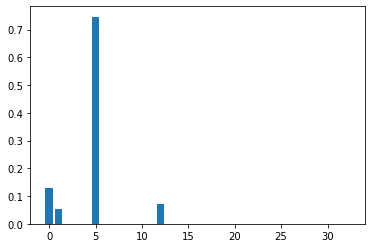

In [99]:
from matplotlib import pyplot
# define dataset
# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Archieve

# SQL Script

In [33]:
from sklearn.tree import export_text

In [34]:
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print node

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(node)? (<ipython-input-34-104c216b393c>, line 30)

In [ ]:
def get_code(tree, feature_names, tabdepth=0):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
#     print("AK",left)
#     print("AK",right)
#     print("AK",threshold)
#     print("AK",features)
#     print("AK",value)
    
    

    def recurse(left, right, threshold, features, node, tabdepth=0):
            if (threshold[node] != -2):
                    print('\t' * tabdepth)
                    print("if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node], tabdepth+1)
                    print('\t' * tabdepth)
                    print ("} else {")
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node], tabdepth+1)
                    print ('\t' * tabdepth)
                    print ("}")
            else:
                    print ('\t' * tabdepth)
                    print ("return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [35]:
clf = DecisionTreeClassifier(random_state=0, max_depth=2, min_samples_leaf = 500)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=2, min_samples_leaf=500, random_state=0)

In [36]:
get_code(clf, FINAL_FEATURES)

NameError: name 'get_code' is not defined

# MOM Gini

In [100]:
gini_dic = {}
predictor_list = []
target_variable = TARGET
df = df[df.FLAG_1PCT_PHANTOM == 1]
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "GM" not in gini_dic: 
            gini_dic["GM"] = []
        if "RGS" not in gini_dic: 
            gini_dic["RGS"] = []
        
        gini_dic["GM"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x][SCORE])-1)*100)
        gini_dic["RGS"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x]["PRED_PROB"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

ERROR
ERROR


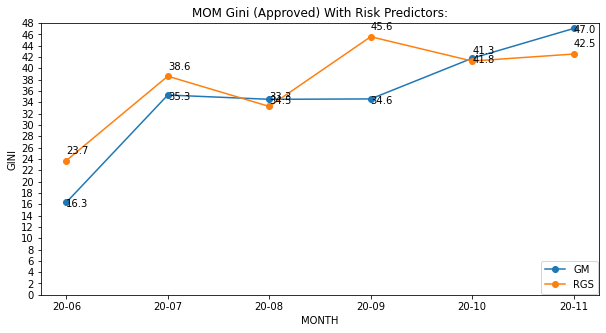

In [102]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["GM"], marker='o', scaley = False, label = "GM")
ax1.plot(gini_df["MONTH"],gini_df["RGS"], marker='o', scaley = False, label = "RGS")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM"][i]-0.8))
for i, txt in enumerate(gini_df["RGS"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["RGS"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,40)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:")
plt.show()

# DOD Gini

In [103]:
gini_df

,index,MONTH,GM,RGS
0,0,20-06,16.313299,23.708025
1,1,20-07,35.280213,38.604420
2,2,20-08,34.523422,33.266916
3,3,20-09,34.590568,45.577151
4,4,20-10,41.767441,41.281381
5,5,20-11,47.030602,42.516898


In [72]:
gini_dic = {}
predictor_list = []
target_variable = TARGET
for x in df["TIME_CREATION_DATE"].unique():
    try:
        if "TIME_CREATION_DATE" not in gini_dic:
            gini_dic["TIME_CREATION_DATE"] = []
        if "GM" not in gini_dic: 
            gini_dic["GM"] = []
        if "RGS" not in gini_dic: 
            gini_dic["RGS"] = []
        
        gini_dic["GM"].append((2*roc_auc_score(df[df["TIME_CREATION_DATE"]==x][target_variable],df[df["TIME_CREATION_DATE"]==x][SCORE])-1)*100)
        gini_dic["RGS"].append((2*roc_auc_score(df[df["TIME_CREATION_DATE"]==x][target_variable],df[df["TIME_CREATION_DATE"]==x]["PRED_PROB"])-1)*100)
        gini_dic["TIME_CREATION_DATE"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "TIME_CREATION_DATE",inplace = True)
gini_df.reset_index(inplace = True)

ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR


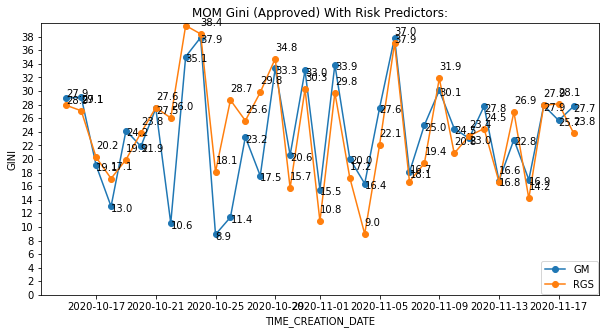

In [74]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["TIME_CREATION_DATE"],gini_df["GM"], marker='o', scaley = False, label = "GM")
ax1.plot(gini_df["TIME_CREATION_DATE"],gini_df["RGS"], marker='o', scaley = False, label = "RGS")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["TIME_CREATION_DATE"][i], gini_df["GM"][i]-0.8))
for i, txt in enumerate(gini_df["RGS"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["TIME_CREATION_DATE"][i], gini_df["RGS"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,40)
plt.ylabel("GINI")
plt.xlabel("TIME_CREATION_DATE")
plt.yticks(np.arange(0,40,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:")
plt.show()